In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [5]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---\ncollecting....")
dataset=mfp.get_manta_files(folder=folder)

os = posix
folder: /tf/notebooks/data/0_manta_selected_annotated_some
 ---
collecting....
total:1801
labelled:295


In [6]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [7]:
image_size=[100,100]
heatmap_size=[17,17]

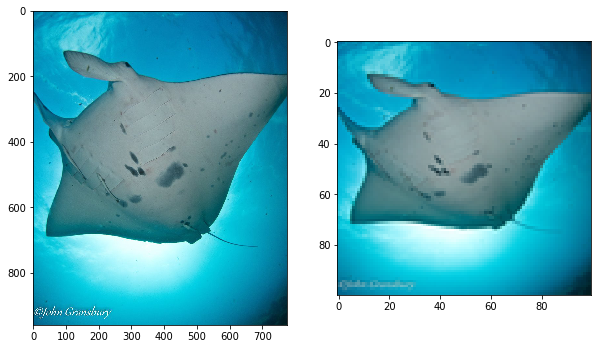

In [8]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,image_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


In [14]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=heatmaps[::-1,:,]
    return flip_image,flip_heatmap

In [15]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    np_image=mfp.image_to_numpy(image,image_size)
    if np_image.shape[2]>3:
        np_image=np_image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)

    if numpy_heatmaps[:,:,:2].sum()==0:
        numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,:2])
        X.append(np_image) 
        #flip_img, flip_hm=flip_image(np_image,numpy_heatmaps)
        #y.append(flip_hm[:,:,4:])
        #X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Done.
X.shape=(19, 100, 100, 3)
y.shape=(19, 17, 17, 2)


In [44]:
copyim=copy.deepcopy(X[5])

In [51]:
copyim2=copy.deepcopy(mfp.denormalize(copyim))

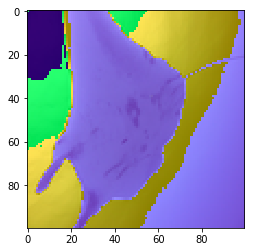

In [53]:
plt.imshow(copyim2)

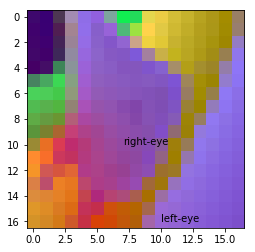

In [56]:
mfp.apply_heatmaps(copyim2,y[5])

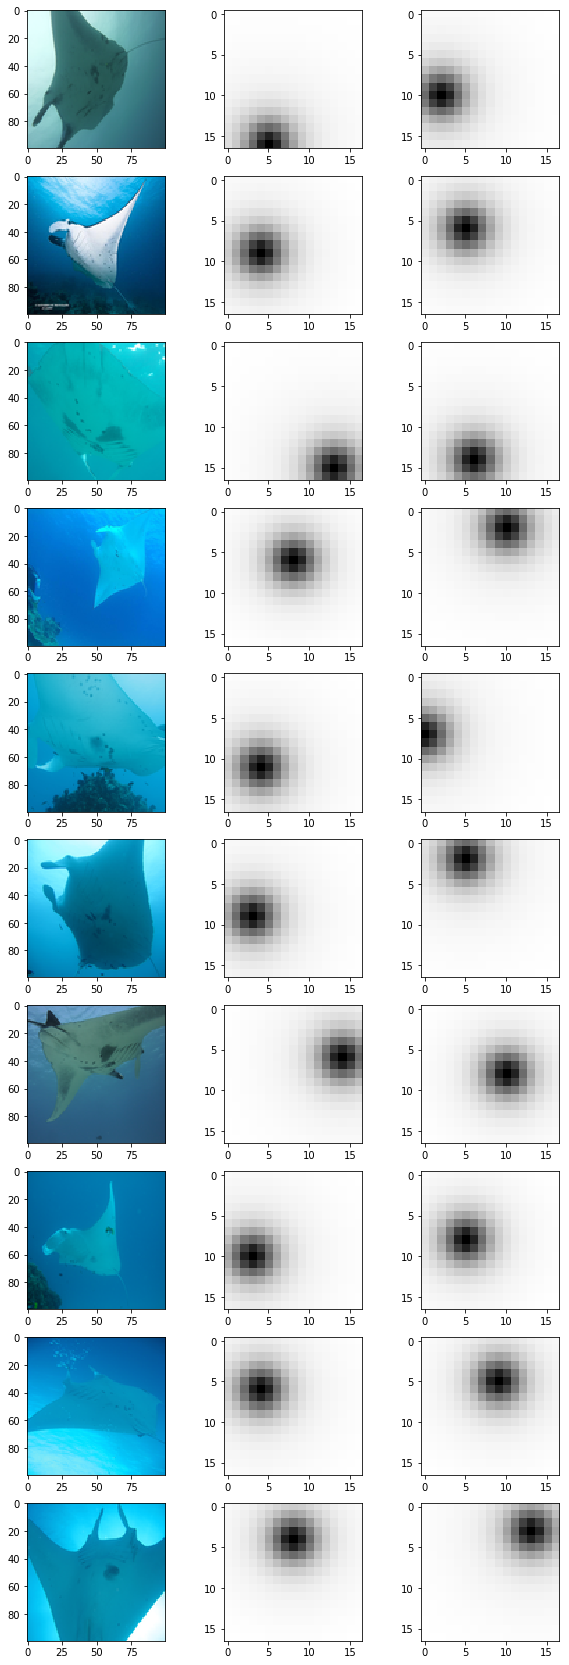

In [16]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y[s][:,:,1],cmap='Greys')
plt.show()


In [18]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [17]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [20]:
mfp.apply_heatmaps(X_train[5],y_train[5])

TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [ ]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

In [ ]:
model=Sequential()
#model.add(vgg16_net)
model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=128,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [ ]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.1)

training_time=round(time.time() - start_time,0)

In [ ]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [ ]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

In [ ]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y_test[s][:,:,0],cmap='Greys')
plt.show()

In [ ]:
mfp.apply_heatmaps(mfp.denormalize(X_test[5]),pred[5])

In [ ]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling
